In [1]:
cd G:\project\fifth_try\data

G:\project\fifth_try\data


In [2]:
ls

 Volume in drive G is New Volume
 Volume Serial Number is BCD7-8E47

 Directory of G:\project\fifth_try\data

07/31/2023  07:52 PM    <DIR>          .
08/04/2023  04:19 PM    <DIR>          ..
07/28/2023  10:14 AM         1,244,952 current_pose_per_episode.npy
07/31/2023  07:33 PM        31,866,960 ep001-loss49.896-val_loss4.488.h5
07/31/2023  07:33 PM        31,866,960 ep002-loss3.721-val_loss3.650.h5
07/31/2023  07:34 PM        31,866,960 ep003-loss3.535-val_loss3.514.h5
07/31/2023  07:35 PM        31,866,960 ep004-loss3.457-val_loss3.477.h5
07/31/2023  07:36 PM        31,866,960 ep005-loss3.430-val_loss3.460.h5
07/31/2023  07:36 PM        31,866,960 ep006-loss3.417-val_loss3.451.h5
07/31/2023  07:37 PM        31,866,960 ep007-loss3.409-val_loss3.445.h5
07/31/2023  07:38 PM        31,866,960 ep008-loss3.405-val_loss3.441.h5
07/31/2023  07:38 PM        31,866,960 ep009-loss3.402-val_loss3.438.h5
07/31/2023  07:39 PM        31,866,960 ep010-loss3.399-val_loss3.436.h5
07/31/2023  07:40 

In [3]:
import numpy as np
image = np.load("W_Image_data_per_episode.npy",mmap_mode='c')
episode_length = np.load("W_Episode.npy",mmap_mode='c')
velocity = np.load("W_Velocity.npy",mmap_mode='c')
r_theta_data = np.load("W_R_T_data.npy",mmap_mode='c')


test_image = np.load("W_test_Image_data_per_episode.npy",mmap_mode='c')
test_episode_length = np.load("W_test_Episode.npy",mmap_mode='c')
test_velocity = np.load("W_test_Velocity.npy",mmap_mode='c')
test_r_theta_data = np.load("W_test_R_T_data.npy",mmap_mode='c')

### astype int32


In [4]:
image = image.astype(np.int32)
test_image = test_image.astype(np.int32)

In [8]:
test_image.shape

(2266, 160, 120, 3)

### Reshape

In [9]:
image = np.reshape(image,[22218,120,160,3])
test_image = np.reshape(test_image,[2266,120,160,3])

In [10]:
velocity = np.around(velocity,decimals=3)
r_theta_data = np.around(r_theta_data,decimals=3)


test_velocity = np.around(test_velocity,decimals=3)
test_r_theta_data = np.around(test_r_theta_data,decimals=3)

In [11]:
image_array = image[15345]

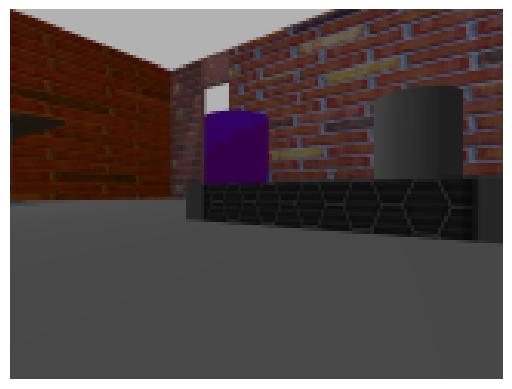

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image_array)
plt.axis('off')  # Optional: turn off axis ticks and labels
plt.show()

In [13]:
from tensorflow.keras.layers import Activation , concatenate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#pip install tensorflow-addons
import tensorflow_addons as tfa

G:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Prepare The Data

In [14]:
input_shape = (120, 160, 3)

x_train = image
y_train = velocity

x_test = test_image
y_test = test_velocity
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")


x_train shape: (22218, 120, 160, 3) - y_train shape: (22218, 2, 3)


# configuring the hyperparameters

In [15]:
learning_rate = 0.01 # used to be 0.01
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 256  # We'll resize input images to this size
patch_size = 64  # Size of the patches to be extract from the input images  ==> used to be 32
num_patches = (image_size // patch_size) ** 2
projection_dim = 4
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# data augmentation

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
        #    height_factor=0.2, width_factor=0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# Implement multilayer perceptron (MLP)



#### using multiple Dense layer

In [17]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Implement patch creation as a layer

In [18]:

#Goal MLP
#Goal is sth like np.array([[1,2]])
'''
Goal = mlp(goal,[16,64,192]) #shape=(1, 192)
tf.reshape(Goal,[6,6,3])
'''
#use it alongside image patches

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        #print("batch_size ==> ",batch_size)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        #3072/3=1024
        #sqrt(1024) = 32
        #32*8=256
        #print('$$patch_size$$ ',patches.shape) #(None, 8, 8, 3072)
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        #print('$$patch_size2$$ ',patches.shape)
        return patches

# Implement the patch encoding layer

##### --> linearly transform a patch by projecting it into a vector of size projection_dim. 
##### --> it adds a learnable position embedding to the projected vector

In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim) #Linear Projection Of Patch-Tockens
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        
        #input_dim ==> encoding number 0 to num_patches -1
        #output_dim ==> self explanatary -> turns every input to output_dim
        #input_length ==> the Maximum length of input sequence 
        '''
        input_dim=10 ==> each word in input
        output_dim=4
        input_length=2
        
        >> input_data = np.array([[1,2]])
        input ->(1, 2)
        output ->[[[ 0.04502351  0.00151128  0.01764284 -0.0089057 ]
                    [-0.04007018  0.02874336  0.02772436  0.00842067]]]
        '''

        
        
    def call(self, patch):
        print('**** num_patches => ',self.num_patches)
        print('**** projection => ',self.projection)
        print('**** position_embedding => ',self.position_embedding)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        print(self.projection(patch))
        encoded = self.projection(patch) + self.position_embedding(positions)
        
        print('**** ',encoded.shape)
        return encoded

# ViT model

In [20]:
def create_vit_classifier():
    image_inputs = layers.Input(shape=input_shape) #shape=(None, 160, 120, 3))
    goal_inputs = layers.Input(shape=(2,))
    # Augment data.
    augmented = data_augmentation(image_inputs) #shape=(None, 256, 256, 3)
    # Create patches.
    patches = Patches(patch_size)(augmented) # shape=(None, None, 3072)
    #print(f'==> {patches.shape}')
    
    #Add Goal to Patches
    Goal = mlp(goal_inputs,[32,512,3072,12288],dropout_rate=0.05)#shape=(None, 3072)
    #Goal = tf.reshape(Goal,[1,1,3072])
    patches = tf.keras.layers.Concatenate(axis=1)([tf.expand_dims(Goal, axis=1),patches]) #shape=(None, None, 3072)

    # Encode patches.
    encoded_patches = PatchEncoder(num_patches+1, projection_dim)(patches) #shape=(1, 64, 4)
    print('encoded_patches ==> ',encoded_patches.shape)
    
    
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        print("$$$im inside the for")
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention( #Self Attention mechanism
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

        
        
        
        # Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.3)(representation)
        #so far we created the image representation
        '''
        Note that the layers.GlobalAveragePooling1D layer could also be used 
        instead to aggregate the outputs of the Transformer block, 
        especially when the number of patches and the projection dimensions are large.
        '''
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
        
    # Classify outputs.##############################################################################################
    linear_vel = layers.Dense(512, activation="relu")(features)
    linear_vel = layers.Dense(128, activation="relu")(linear_vel)
    linear_vel = layers.Dense(32, activation="relu")(linear_vel)
    linear_vel = layers.Dense(8, activation="relu")(linear_vel)
    linear_vel = layers.Dense(1,)(linear_vel)                        
    linear_net =Activation("linear", name="linear_output")(linear_vel)                  
                                                                                        
                                                                                         
    angular_vel = layers.Dense(512, activation="relu")(features)
    angular_vel = layers.Dense(128, activation="relu")(angular_vel)
    angular_vel = layers.Dense(32, activation="relu")(angular_vel)
    angular_vel = layers.Dense(8, activation="relu")(angular_vel)
    angular_vel = layers.Dense(1,)(angular_vel)                        
    angular_net =Activation("linear", name="angular_output")(angular_vel)
                                                                                         
    
    
    # Create the Keras model.##############################################################################
    model = keras.Model(inputs=[image_inputs,goal_inputs], outputs=[linear_net,angular_net])             
    return model

# Compile The Model

In [21]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
#######################################################################################################################33    
    losses={'linear_output':'mse','angular_output':'mse'}                      #########################################
    weight={'linear_output':1,'angular_output':4}                                                                                   ################################
    model.compile(
        optimizer=optimizer,
        loss=losses,
        metrics={ 'linear_output':"mean_squared_error",'angular_output': "mean_squared_error"},loss_weights=weight)
    
    log_dir = ''
    checkpoint_filepath = log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
    checkpoint_callback = keras.callbacks.ModelCheckpoint( 
        #callback is an object that can perform actions at various stages of training
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=[x_train,r_theta_data],
        y=[y_train[:,0,0],y_train[:,1,2]],
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(
            [x_test,test_r_theta_data],
            [y_test[:,0,0],y_test[:,1,2]]
        ),
        callbacks=[checkpoint_callback],
        shuffle=False
    )

    model.load_weights(checkpoint_filepath)
 #   _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  #  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
   # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    
    model.save('')
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

**** num_patches =>  17
**** projection =>  <keras.layers.core.dense.Dense object at 0x000001DC2CEEE8B0>
**** position_embedding =>  <keras.layers.core.embedding.Embedding object at 0x000001DC2CEEEC10>
Tensor("patch_encoder/dense_4/BiasAdd:0", shape=(None, None, 4), dtype=float32)
****  (None, 17, 4)
encoded_patches ==>  (None, 17, 4)
$$$im inside the for
$$$im inside the for
Epoch 1/100
**** num_patches =>  17
**** projection =>  <keras.layers.core.dense.Dense object at 0x000001DC2CEEE8B0>
**** position_embedding =>  <keras.layers.core.embedding.Embedding object at 0x000001DC2CEEEC10>
Tensor("model/patch_encoder/dense_4/BiasAdd:0", shape=(None, None, 4), dtype=float32)
****  (None, 17, 4)
**** num_patches =>  17
**** projection =>  <keras.layers.core.dense.Dense object at 0x000001DC2CEEE8B0>
**** position_embedding =>  <keras.layers.core.embedding.Embedding object at 0x000001DC2CEEEC10>
Tensor("model/patch_encoder/dense_4/BiasAdd:0", shape=(None, None, 4), dtype=float32)
****  (None, 

KeyboardInterrupt: 